<a href="https://colab.research.google.com/github/vadimvik/tabular_playground_series_jan_2021/blob/main/tabular_playground_series_jan_2021_lgb_cat_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#подключим google disk
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install catboost

     |████████████████████████████████| 65.8MB 62kB/s 


In [ ]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool


In [ ]:
%matplotlib inline

read data

In [ ]:
ROOT = Path.cwd().parent
INPUT = ROOT / "content/drive/My Drive/Datasets/"  # ROOT /
DATA = INPUT / "tabular-playground-series-jan-2021"
#WORK = ROOT / "working"

for path in DATA.iterdir():
    print(path.name)

sample_submission.csv
test.csv
train.csv
submission_lgbm_1.csv
submission_lgbm_2.csv


In [ ]:
ROOT

PosixPath('/')

In [ ]:
train = pd.read_csv(DATA / "train.csv")
test = pd.read_csv(DATA / "test.csv")
smpl_sub = pd.read_csv(DATA / "sample_submission.csv")
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (300000, 16), test: (200000, 15), sample sub: (200000, 2)


In [ ]:
train.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


Definition

In [ ]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

Training & Inference

Config

In [ ]:
ID_COL = "id"
FEAT_COLS = [f"cont{i}" for i in range(1, 15)]
TGT_COL = "target"

N_SPLITS = 5
RANDOM_SEED_LIST = [
    1003 #,2021,719
]

MODEL_PARAMS = {
    "lgb": {
        'seed': RANDOM_SEED_LIST[0],
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
        'lambda_l1': 6.540486456085813,
        'lambda_l2': 0.01548480538099245,
        'num_leaves': 256,
        'feature_fraction': 0.52,
        'bagging_fraction': 0.6161835249194311,
        'bagging_freq': 7,
        'min_child_samples': 20,
        'learning_rate': 0.005,
    },

    "xgb": {
        "objective": "reg:squarederror",
        "learning_rate": 0.005,
        "seed": RANDOM_SEED_LIST[0],
        'alpha': 0.01563,
        'base_score': 0.5,
        'booster': 'gbtree',
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'colsample_bytree': 0.5,
        'gamma': 0,
        'importance_type': 'gain',
        'interaction_constraints': '',
        'max_delta_step': 0,
        'max_depth': 15,
        'metric_period': 100,
        'min_child_weight': 257,
        'n_jobs': 0,
        'num_parallel_tree': 1,
        'reg_alpha': 0.0156299993,
        'reg_lambda': 0.003,
        'scale_pos_weight': 1,
        'silent': 1,
        'subsample': 0.7,
        'tree_method': 'exact',
        'validate_parameters': 1,
        'verbosity': 1
    },
    "cat": {
        'loss_function': 'RMSE',
        'learning_rate': 0.005,
        'max_depth': 7,
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
    #     "task_type": "GPU",
    #     "devices" : "0",
        'num_boost_round': 20000
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 100,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval":  100,
    },
    "cat": {'early_stopping_rounds': 200, 'verbose_eval': 100}
}

In [ ]:
train

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499995,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,0.315397,0.247682,0.486542,0.288750,7.385215
299996,499996,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,0.360251,0.360755,0.292535,0.619984,7.242617
299997,499997,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,0.491735,0.516629,0.173521,0.714552,9.592487
299998,499998,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,0.984647,1.001110,0.063956,0.377693,8.207951


Feature Engineering

In [ ]:
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()

In [ ]:
train

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499995,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,0.315397,0.247682,0.486542,0.288750,7.385215
299996,499996,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,0.360251,0.360755,0.292535,0.619984,7.242617
299997,499997,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,0.491735,0.516629,0.173521,0.714552,9.592487
299998,499998,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,0.984647,1.001110,0.063956,0.377693,8.207951


raw features

In [ ]:
train_feat = pd.concat([
    train_feat, train[FEAT_COLS]], axis=1)
test_feat = pd.concat([
    test_feat, test[FEAT_COLS]], axis=1)
use_feat_cols.extend(FEAT_COLS)

Training

In [ ]:
def run_train_and_inference(X, X_test, y, use_model, model_params, train_params, seed_list, n_splits):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params)
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

In [ ]:
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (300000, 14), test_feat: (200000, 14)


In [ ]:
X

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,0.315397,0.247682,0.486542,0.288750
299996,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,0.360251,0.360755,0.292535,0.619984
299997,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,0.491735,0.516629,0.173521,0.714552
299998,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,0.984647,1.001110,0.063956,0.377693


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37b3dcfd68>,
      dtype=object)

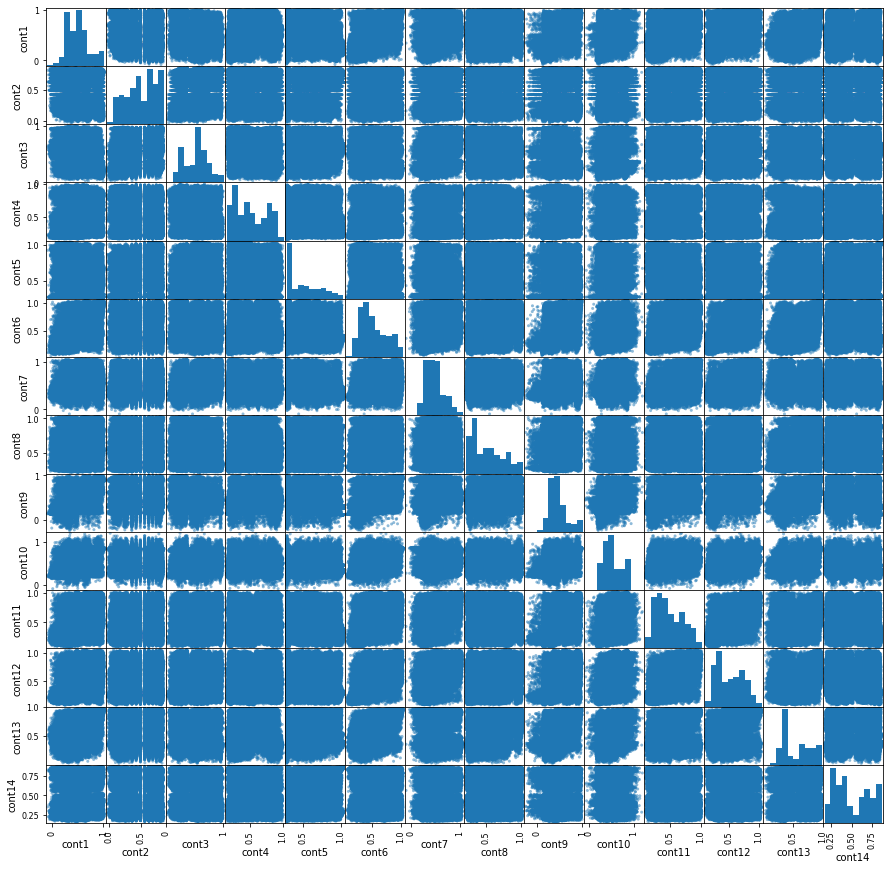

In [ ]:
pd.plotting.scatter_matrix(X, alpha=0.5, figsize=(15, 15))

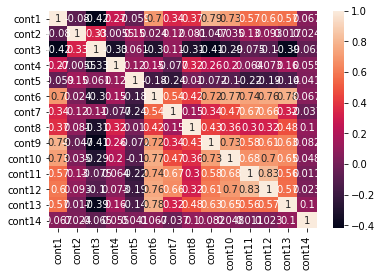

In [ ]:
sns.heatmap(X.corr(), annot = True, fmt='.2g')

In [ ]:
# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

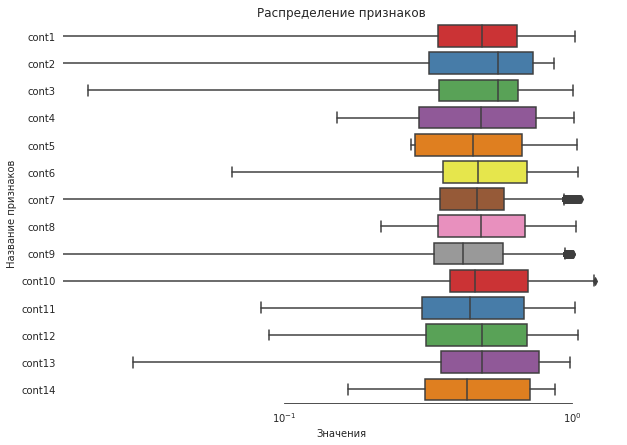

In [ ]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=X , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Название признаков")
ax.set(xlabel="Значения")
ax.set(title="Распределение признаков")
sns.despine(trim=True, left=True)

In [ ]:
# Find skewed numerical features
skew_features = X.apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 6 numerical features with Skew > 0.5 :


cont9     0.796229
cont7     0.703408
cont5     0.610301
cont8     0.569725
cont6     0.537973
cont1     0.529575
cont11    0.419387
cont10    0.362599
cont13    0.320348
cont12    0.283172
dtype: float64

In [ ]:
# Нормализуем смещение признаков
for i in skew_index:
  X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


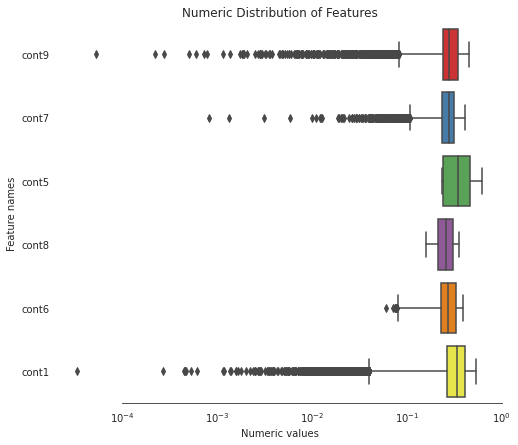

In [ ]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=X[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [ ]:
# Find skewed numerical features
skew_features = X.apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 0 numerical features with Skew > 0.5 :


cont11    0.419387
cont5     0.413519
cont10    0.362599
cont13    0.320348
cont12    0.283172
cont14    0.252547
cont4     0.250382
cont8     0.073953
cont3     0.009037
cont7     0.002527
dtype: float64

In [ ]:
X

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.423617,0.811300,0.643968,0.291791,0.239007,0.360122,0.385551,0.191423,0.336206,0.779418,0.921832,0.866772,0.878733,0.305411
1,0.289682,0.621104,0.686102,0.501149,0.454562,0.264685,0.294716,0.284682,0.280276,0.432632,0.439872,0.434971,0.369957,0.369484
2,0.484603,0.227436,0.301584,0.293408,0.435517,0.355682,0.293195,0.279653,0.346505,0.823312,0.567007,0.677708,0.882938,0.303047
3,0.479712,0.160155,0.546887,0.726104,0.237816,0.347945,0.358729,0.327777,0.341951,0.580843,0.769594,0.818143,0.914281,0.279528
4,0.517241,0.421235,0.303801,0.880214,0.465537,0.355844,0.286876,0.289793,0.427887,0.863427,0.983575,0.900464,0.935918,0.435772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.182205,0.735265,0.648648,0.255387,0.440477,0.225480,0.208683,0.199502,0.229668,0.860504,0.315397,0.247682,0.486542,0.288750
299996,0.369865,0.165139,0.220966,0.190053,0.290450,0.241938,0.240790,0.215416,0.300903,0.454581,0.360251,0.360755,0.292535,0.619984
299997,0.227591,0.841542,0.957585,0.340383,0.314291,0.219181,0.299461,0.179834,0.261776,0.526925,0.491735,0.516629,0.173521,0.714552
299998,0.339209,0.622346,0.540032,0.823118,0.238259,0.259394,0.140255,0.310273,0.252344,0.648272,0.984647,1.001110,0.063956,0.377693


LightGBM

In [ ]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

In [ ]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 1003 - Fold: 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.71895	valid_1's rmse: 0.723517
[200]	training's rmse: 0.70973	valid_1's rmse: 0.716543
[300]	training's rmse: 0.702896	valid_1's rmse: 0.711929
[400]	training's rmse: 0.69756	valid_1's rmse: 0.708837
[500]	training's rmse: 0.693083	valid_1's rmse: 0.706562
[600]	training's rmse: 0.689213	valid_1's rmse: 0.704872
[700]	training's rmse: 0.685706	valid_1's rmse: 0.703516
[800]	training's rmse: 0.682507	valid_1's rmse: 0.702435
[900]	training's rmse: 0.679536	valid_1's rmse: 0.701554
[1000]	training's rmse: 0.676767	valid_1's rmse: 0.700847
[1100]	training's rmse: 0.67414	valid_1's rmse: 0.700253
[1200]	training's rmse: 0.671634	valid_1's rmse: 0.699778
[1300]	training's rmse: 0.669243	valid_1's rmse: 0.699357
[1400]	training's rmse: 0.666932	valid_1's rmse: 0.698984
[1500]	training'

In [ ]:
score_lgb

,seed,fold,rmse score
0,1003,0,0.697087
1,1003,1,0.697465
2,1003,2,0.695118
3,1003,3,0.694790
4,1003,4,0.693725
5,1003,oof,0.695639
6,avg,oof,0.695639


In [ ]:
score_lgb.loc[score_lgb.fold == "oof"]

,seed,fold,rmse score
5,1003,oof,0.695639
6,avg,oof,0.695639


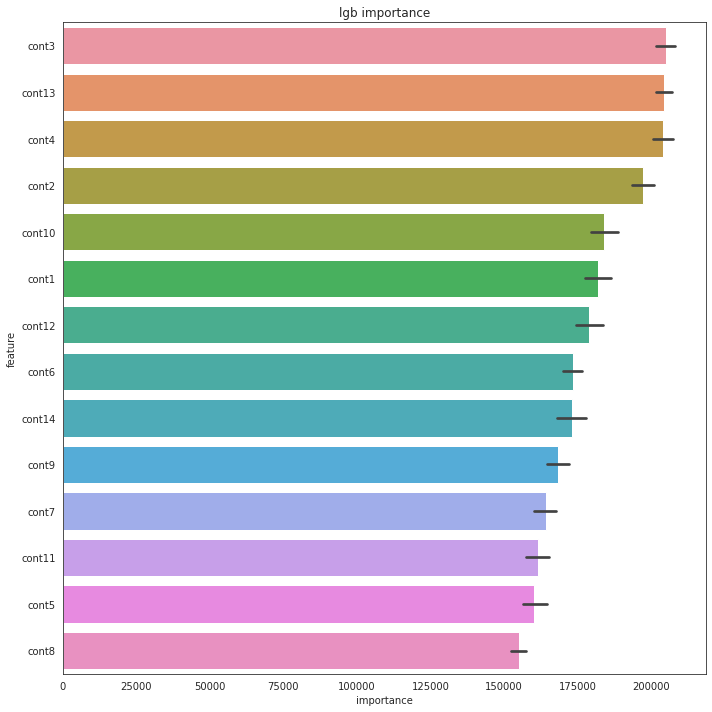

In [ ]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

XGBoost

In [ ]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 1003 - Fold: 0
[0]	train-rmse:7.40467	val-rmse:7.4063
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:4.52068	val-rmse:4.52287
[200]	train-rmse:2.79432	val-rmse:2.79788
[300]	train-rmse:1.77992	val-rmse:1.78612
[400]	train-rmse:1.20857	val-rmse:1.21907
[500]	train-rmse:0.911056	val-rmse:0.926791
[600]	train-rmse:0.77153	val-rmse:0.79221
[700]	train-rmse:0.711624	val-rmse:0.736106
[800]	train-rmse:0.686491	val-rmse:0.713913
[900]	train-rmse:0.675475	val-rmse:0.705259
[1000]	train-rmse:0.66986	val-rmse:0.70175
[1100]	train-rmse:0.666555	val-rmse:0.700238
[1200]	train-rmse:0.664103	val-rmse:0.699511
[1300]	train-rmse:0.662195	val-rmse:0.699105
[1400]	train-rmse:0.660428	val-rmse:0.698841
[1500]	train-rmse:0.658921	val-rmse:0.698624
[1600]	train-rmse:0.657551	val-rmse:0.69848

In [ ]:
score_xgb

,seed,fold,rmse score
0,1003,0,0.697609
1,1003,1,0.697846
2,1003,2,0.695332
3,1003,3,0.695433
4,1003,4,0.694308
5,1003,oof,0.696107
6,avg,oof,0.696107


In [ ]:
score_xgb.loc[score_xgb.fold == "oof"]

,seed,fold,rmse score
5,1003,oof,0.696107
6,avg,oof,0.696107


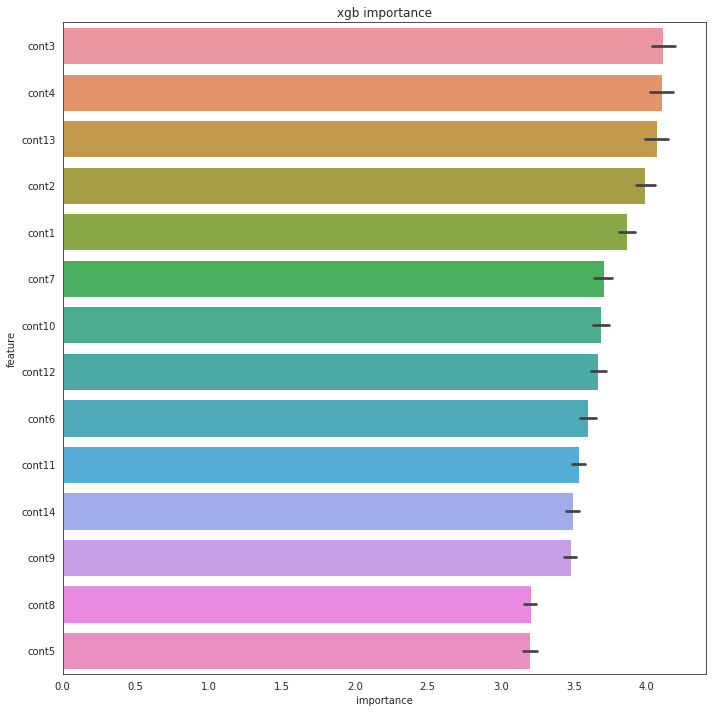

In [ ]:
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

CatBoost

In [ ]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 1003 - Fold: 0
0:	learn: 0.7324960	test: 0.7348119	best: 0.7348119 (0)	total: 133ms	remaining: 44m 23s
100:	learn: 0.7251065	test: 0.7274060	best: 0.7274060 (100)	total: 5.49s	remaining: 18m 1s
200:	learn: 0.7212077	test: 0.7236074	best: 0.7236074 (200)	total: 10.7s	remaining: 17m 33s
300:	learn: 0.7185185	test: 0.7210064	best: 0.7210064 (300)	total: 15.9s	remaining: 17m 22s
400:	learn: 0.7165379	test: 0.7191409	best: 0.7191409 (400)	total: 21.2s	remaining: 17m 17s
500:	learn: 0.7149288	test: 0.7176284	best: 0.7176284 (500)	total: 26.5s	remaining: 17m 9s
600:	learn: 0.7136380	test: 0.7164456	best: 0.7164456 (600)	total: 31.6s	remaining: 17m
700:	learn: 0.7125533	test: 0.7154538	best: 0.7154538 (700)	total: 36.7s	remaining: 16m 51s
800:	learn: 0.7115879	test: 0.7146051	best: 0.7146051 (800)	total: 41.9s	remaining: 16m 43s
900:	learn: 0.7107392	test: 0.7138714	best: 0.7138714 (900)	

In [ ]:
score_cat

,seed,fold,rmse score
0,1003,0,0.698819
1,1003,1,0.699602
2,1003,2,0.697072
3,1003,3,0.696430
4,1003,4,0.695922
5,1003,oof,0.697570
6,avg,oof,0.697570


In [ ]:
score_cat.loc[score_cat.fold == "oof"]

,seed,fold,rmse score
5,1003,oof,0.69757
6,avg,oof,0.69757


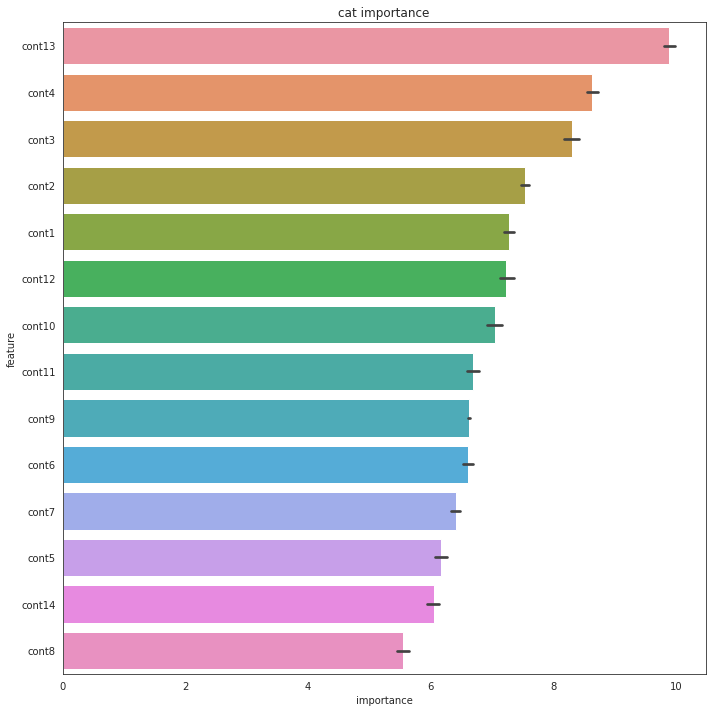

In [ ]:
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

Ensemble LGB, XGB, Cat¶


averaging

In [ ]:
oof_pred_avg = oof_pred_lgb*0.5 + oof_pred_xgb*0.3 + oof_pred_cat*0.2
#oof_pred_avg = oof_pred_lgb*0.6 + oof_pred_xgb*0.4

#oof_pred_avg = oof_pred_lgb

oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

oof score avg: 0.69562


In [ ]:
test_pred_avg = test_pred_lgb*0.5 + test_pred_xgb*0.3 + test_pred_cat*0.2
#test_pred_avg = test_pred_lgb*0.6 + test_pred_xgb*0.4
#test_pred_avg = test_pred_lgb

Make submission¶


In [ ]:
sub = smpl_sub.copy()
sub[TGT_COL] = test_pred_avg

sub.to_csv("/content/drive/My Drive/Datasets/tabular-playground-series-jan-2021/submission_lgbm_6.csv", index=False)

sub.head()

,id,target
0,0,8.452557
1,2,7.948724
2,6,8.068437
3,7,8.516314
4,10,8.504481
